# Why Is Everyone at Kaggle Obsessed with Optuna For Hyperparameter Tuning?
## Let's find out by trying it out...
![](images/pixabay.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://pixabay.com/users/bomei615-2623913/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1751855'>Bo Mei</a>
        on 
        <a href='https://pixabay.com/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1751855'>Pixabay.</a> All images are by author unless specified otherwise.
    </strong>
</figcaption>

## Setup

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns

optuna.logging.set_verbosity(optuna.logging.WARNING)

## Introduction

Turns out, I have been living under a rock...

Every single MOOC I have taken taught me to use GridSearch for hyperparameter tuning. Naively, I loved it and went the extra mile to learn its cousins - Randomized GridSearch and Halving GridSearch.

Even though they were great, I somehow tried to avoid hyperparameter tuning as much as possible. Why?

First, they take such a damn long time to train. We are talking in multiples of 24-hour sessions if you are doing an exhaustive GridSearch. If you are not, then there is a pretty high chance randomized search comes up with hyperparameters that are actually worse than the defaults.

While I was complaining, Kagglers have been using Optuna almost exclusively for the past 2 years to do hyperparameter tuning. 

After giving it a try, I am truly amazed at how it takes the whole tuning experience to the next level. So, without further ado, let me show you how to use it in your own workflow.

## What is Optuna?

![](https://raw.githubusercontent.com/optuna/optuna/master/docs/image/optuna-logo.png)
<figcaption style="text-align: center;">
    <strong>
        Optuna logo
    </strong>
</figcaption>

Optuna is a next-generation automatic hyperparameter tuning framework, written completely in Python.

Its most prominent features are:
- the ability to define Pythonic search spaces using loops and conditionals. 
- completely platform agnostic API - using Optuna, you can tune estimators of almost any ML, DL package/framework including Sklearn, PyTorch, TensorFlow, Keras, XGBoost, LightGBM, CatBoost, etc.
- a large suite of optimization algorithms with early stopping and pruning features baked in.
- easy parallelization with little or no changes to the code.
- built-in support for visual exploration of search results.

## Optuna basics

Let's familiarize ourselves with Optuna API by tuning a simple function like $(x-1)^2 + (y+3)^2$. We know the function converges to its minimum at x=1 and y=-3. Let's see if Optuna can find these:

In [8]:
import optuna  # pip install optuna


def objective(trial):
    x = trial.suggest_float("x", -7, 7)
    y = trial.suggest_float("y", -7, 7)
    return (x - 1) ** 2 + (y + 3) ** 2

After importing `optuna`, we define an objective that returns the function we want to minimize. 

In the body of the objective, we define the parameters to be optimized, in this case simple `x` and `y`. The argument `trial` is a special Trial object of optuna which does the optimization for each hyperparameter. 

Along many others, it has a `suggest_float` method which takes the name of the hyperparameter and the range to look for its optimal value. In other words

```
x = trial.suggest_float("x", -7, 7)
```
is almost the same as `{"x": np.arange(-7, 7)}` when doing GridSearch.

To start the optimization, we create a `study` object from Optuna and pass the `objective` function to its `optimize` method:

In [11]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)  # number of iterations

In [13]:
study.best_params

{'x': 0.8806708977164549, 'y': -3.0941841160297767}

Pretty close but not as close as you would want. Here, we only did 100 trials, as can be seen with:

In [15]:
len(study.trials)

100

Here, I will introduce the first magic that comes with Optuna. We can resume the optimization even after it is finished if we are not satisfied with the results! 

This is a huge advantage over other tools because after the search is done, they completely forget the history of previous trials. Optuna does not!

To continue searching, just call `optimize` again with the desired params. Here, we will add 100 more trials:

In [21]:
study.optimize(objective, n_trials=100)

In [22]:
study.best_params

{'x': 1.045706853335669, 'y': -2.9501109059847512}

As you can see, the results are much closer to the optimal parameters. 

## A note on Optuna terminology and conventions

In Optuna, the whole optimization process is called a *study*. For example, tuning XGBoost parameters with a log loss as a metric is one study:

In [34]:
study = optuna.create_study()
type(study)

optuna.study.Study

Study needs a function it can optimize. Typically, this function is defined by the user and by convention, it should be named `objective`. 

The objective function is expected to have this signature:

In [35]:
def objective(trial: optuna.Trial):
    """Conventional optimization function
    signature for optuna.
    """
    custom_metric = ...
    return custom_metric

It should accept `optuna.Trial` object as a parameter and return the metric we want to optimize for. 

As we saw in the first example, a study is a collection of *trials* where in each trial, we evaluate the objective function using a single set of hyperparameters from the given search space. 

Each trial in the study is represented as `optuna.Trial` class. This class is key to how Optuna finds optimal values for parameters. 

To start a study, we create a study object with `direction`:

In [36]:
study = optuna.create_study(direction="maximize")

If the metric we want to optimize is a point-performance score like ROC AUC or accuracy, we set the direction to `maximize`. Otherwise, we minimize a loss function like RMSE, RMSLE, log loss, etc. by setting direction to `minimize`. 

Then, we will call the `optimize` method of the study passing the objective function name and the number of 
trials we want:

```python
# Optimization with 100 trials
study.optimize(objective, n_trials=100)
```

Next, we will take a closer look into creating the objective functions.

## Defining the search space

Usually, the first thing you do in an objective function is to create the search space using built-in Optuna methods:

In [39]:
def objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_integer(name="n_estimators", low=100, high=2000),
        "max_depth": trial.suggest_float("max_depth", 3, 8),
        "max_features": trial.suggest_categorical(
            "max_features", choices=["auto", "sqrt", "log2"]
        ),
        "n_jobs": -1,
        "random_state": 1121218,
    }

    rf = RandomForestRegressor(**rf_params)
    ...

In the above objective function, we are creating a small search space of Random Forest hyperparameters. 

The search space is a plain-old dictionary. To create possible values to search over, you must use trial object's `suggest_*` functions. 

These functions require at least the hyperparameter name, min and max of the range to search over or possible categories for categorical hyperparameters.

To make the space smaller, `suggest_float` and `suggest_int` have additional `step` or `log` arguments:

In [43]:
from sklearn.ensemble import GradientBoostingRegressor


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000, step=200),
        "learning_rate": trial.suggest_float("learning_rate", 1e7, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12, step=2),
        "random_state": 1121218,
    }
    boost_reg = GradientBoostingRegressor(**params)
    rmsle = ...
    return rmsle

Above we are binning the distribution of `n_estimators` by 200-intervals to make it sparser. Also, `learning_rate` is defined at a logarithmic scale. 

## How are possible parameters sampled?

Under the hood, Optuna has a number of classes responsible for parameter sampling. These are:
- `GridSampler`: the same as GridSearch of Sklearn. Never use for large search spaces!
- `RandomSampler`: the same as RandomizedGridSearch of Sklearn.
- `TPESampler`: Tree-structured Parzen Estimator sampler - bayesian optimization using kernel fitting
- `CmaEsSampler`: a sampler based on CMA ES algorithm (does not allow categorical hyperparameters).

> I have no idea of how the last two samplers work and I don't expect this to affect any interaction I have with Optuna. 

Just know that TPE Sampler is used by default - it tries to sample hyperparameter candidates by trying to improve on the last trial's scores. In other words, you can expect an incremental (maybe marginal) iprovements from trial to trial with this sampler.

If you ever want to switch samplers, this is how you do it:

In [44]:
from optuna.samplers import CmaEsSampler, RandomSampler

# Study with a random sampler
study = optuna.create_study(sampler=RandomSampler(seed=1121218))

# Study with a CMA ES sampler
study = optuna.create_study(sampler=CmaEsSampler(seed=1121218))

## End-to-end example with GradientBoostingRegressor

Let's put everything we have learned into something tangible. We will be predicting penguin body weights using a number of numeric and categorical features. 

We will establish a base score with Sklearn GradientBoostingRegressor and improve it by tuning with Optuna:

In [50]:
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate, train_test_split

# Load data
penguins = sns.load_dataset("penguins").dropna()
X, y = penguins.drop("body_mass_g", axis=1), penguins[["body_mass_g"]]

# OH encode categoricals
X = pd.get_dummies(X)

# Init model with defaults
gr_reg = GradientBoostingRegressor(random_state=1121218)

kf = KFold(n_splits=5, shuffle=True, random_state=1121218)
scores = cross_validate(
    gr_reg, X, y, cv=kf, scoring="neg_mean_squared_log_error", n_jobs=-1
)

In [53]:
rmsle = np.sqrt(-scores["test_score"].mean())
print(f"Base RMSLE: {rmsle:.5f}")

Base RMSLE: 0.07573


Now, we will create the `objective` function and define the search space:

In [58]:
def objective(trial, X, y, cv, scoring):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        ),
        "random_state": 1121218,
        "n_iter_no_change": 50,  # early stopping
        "validation_fraction": 0.05,
    }
    # Perform CV
    gr_reg = GradientBoostingRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    # Compute RMSLE
    rmsle = np.sqrt(-scores["test_score"].mean())

    return rmsle

This objective function is slightly different - it accepts additional arguments for the data sets, scoring and `cv`. That's why we have to wrap it inside another function. Generally, you do this with a `lambda` function like below (only if the `objective` accepts more than just `trial` object):

In [59]:
%%time

# Create study that minimizes
study = optuna.create_study(direction="minimize")
# Wrap the objective inside a lambda with the relevant arguments
kf = KFold(n_splits=5, shuffle=True, random_state=1121218)
# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kf, scoring="neg_mean_squared_log_error")

# Start optimizing with 100 trials
study.optimize(func, n_trials=100)

Wall time: 1min 3s


In [62]:
print(f"Base RMSLE    : {rmsle:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

Base RMSLE    : 0.07573
Optimized RMSE: 0.07177


In just over a minute, we achieved a significant score boost (in terms of log errors, 0.004 is pretty huge). We did this with just 100 trials. Let's boldly give another 200 trials and see what happens:

In [65]:
%%time

study.optimize(func, n_trials=200)

Wall time: 1min


In [66]:
print(f"Base RMSLE    : {rmsle:.5f}")
print(f"Optimized RMSE: {study.best_value:.5f}")

Base RMSLE    : 0.07573
Optimized RMSE: 0.07155


The score *did* improve but marginally. Looks like we hit it close to the max in the first run!

Most importantly, we achieved this score in just 2 minutes using a search space which would probably take hours with regular GridSearch. 

I don't know about you, but I am sold!

## Using visuals for more insights and smarter tuning

Optuna offers a wide range of plots under its `visualization` subpackage. Here, we will discuss only 2 which I think are the most useful.

First, let's plot the optimization history of the last `study` object:

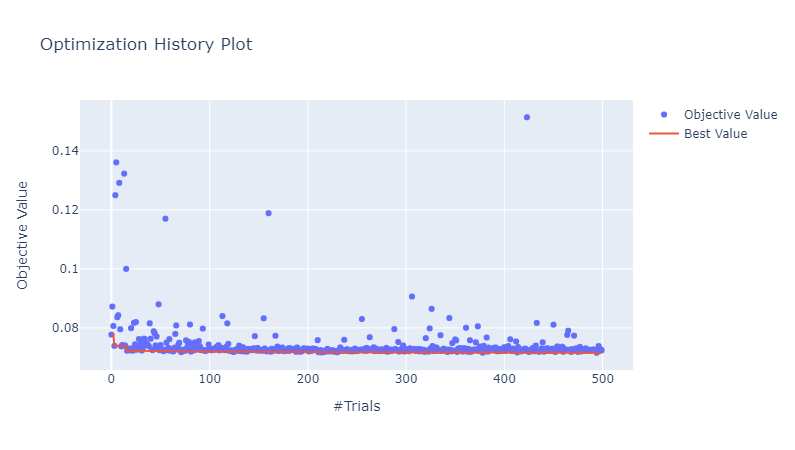

In [70]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

This plot tells us that Optuna made the score converge to the minimum after only a few trials.

Next, let's plot hyperparameter importances:

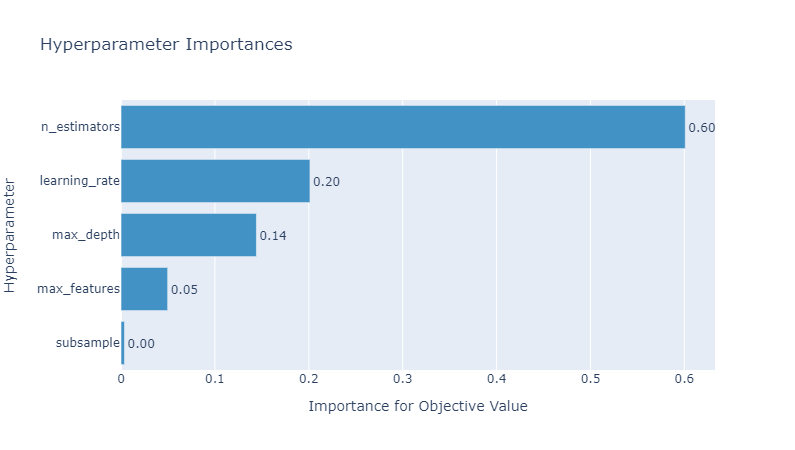

In [71]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

This plot is massively useful! It tells us a number of things, including:
- `n_estimators` and `learning_rate` are the most important parameters
- `subsample` is useless for maximizing the loss in this case

A plot like this comes in handy when tuning models with many hyperparameters. For example, you could run 40-50 trials and plot the parameter importances.

Depending on the plot, you might make a decision to discard some useless parameters and give a larger search space for the most important ones and start heavy-duty tuning being much prepared.

You can check out [this page](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html) of the documentation for more information on Optuna's supported plot types. 